# Bayesian Analysis of Math Exam Scores

## Problem Statement

You are provided with a dataset of math exam scores from Estonian primary schools. Your task is to build a Bayesian model to better understand the factors that influence exam performance.

## Data Description

The dataset includes the following variables:
- `year`: The year of the exam (2016-2023)
- `county`: The county where the student took the exam
- `domestic_background`: Whether the student is Estonian or Russian
- `gender`: Student's gender (Male/Female)
- `avg_grade`: The student's average grade (from 1 to 5, continuous)
- `exam_score`: The exam score (0-50 points)

## Your Task

1. Load and explore the data to understand its structure. 
2. Perform exploratory data analysis to investigate the relationships between variables. 
3. Create a DAG that represents the causal relationships between variables based on your domain knowledge. This DAG will help inform the structure of your Bayesian model, the choice of priors, and the conditional dependencies.
4. Based on the DAG, build a Bayesian model to analyze the following relationships:
   - How does the county influence exam scores?
   - What is the impact of domestic background (Estonian vs Russian) on exam performance?
   - Are there gender differences in exam scores?
   - How have exam scores evolved over time across different years (2016–2023)?
5. Visualize and interpret your results. Specifically, try to answer the following questions:
   - What is the posterior probability of getting a >=45 `exam_score` if `avg_grade` before taking the exam is less than 2.5?
   - What is the posterior distribution of the difference in exam performance between students of Estonian and Russian domestic backgrounds?
   - How has the posterior distribution of exam performance changed over the years (2016-2023)?
   - What is the posterior distribution of the relationship between `avg_grade` and `exam_score` across different counties?
   - What are the posterior distributions of gender differences in exam performance across counties?
   - What is the posterior probability that a student with an `avg_grade` of 4.5 will score at least 40 points?


#### From Margus & Tarmo:
*If you want to build a good model, draw the causal graph and then really plot the relationships -- as they are not simple here. But you should start with the simple linear model and then just go down the rabbit hole and see how deep it goes. A keyword that might help is "Heteroskedacity".*

## Data Loading

In [199]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('math_exam_scores.csv', sep=";").sample(2000) # Work with a smaller dataset at first so that you don't have to wait 10 minutes every time you sample the model.
df = pd.read_csv('math_exam_scores.csv', sep=";") # Work with a smaller dataset at first so that you don't have to wait 10 minutes every time you sample the model.

# Display first few rows
df.head()

#df.describe()


,year,county,domestic_background,gender,exam_score,avg_grade
0,2016,Harjumaa,Estonian,Male,31,3.740252
1,2016,Harjumaa,Estonian,Female,39,4.160213
2,2016,Harjumaa,Estonian,Female,30,3.247244
3,2016,Saaremaa,Estonian,Male,45,4.748535
4,2016,Harjumaa,Estonian,Male,46,4.773581


## Hints
It might come handy to know that:
- The `exam_score` is a linear combination of the `primary influencing factor`, along with the `sigmoid` of linear combination of some `other factors`. There is no noise in the `sigmoid` function.
- The `sigmoid` is shifted down by 0.5 such that its range is (-0.5,0.5). Futhermore `sigmoid` is weigtened by `primary influencing factor`*(5-`primary influencing factor`) to reduce the influence of other factors at extreme values of exam scores (near 0 and 50).
- The `exam_score` is generated in such a way that its noise varies. The variance of the noise is smaller near the extreme values (0 and 50).

Good luck with your analysis!

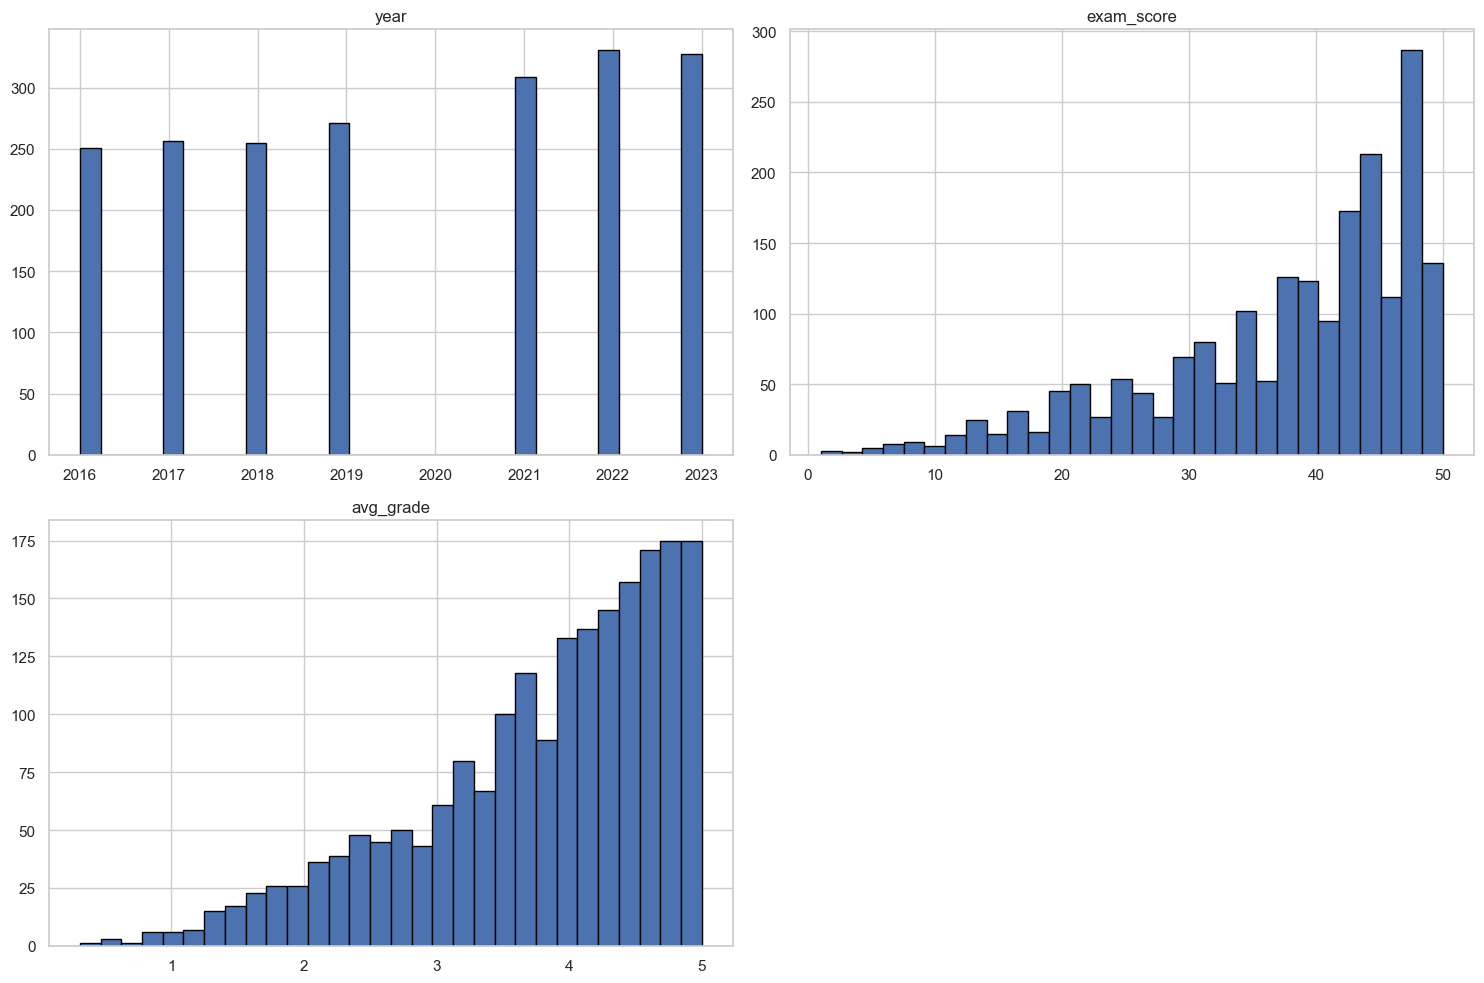

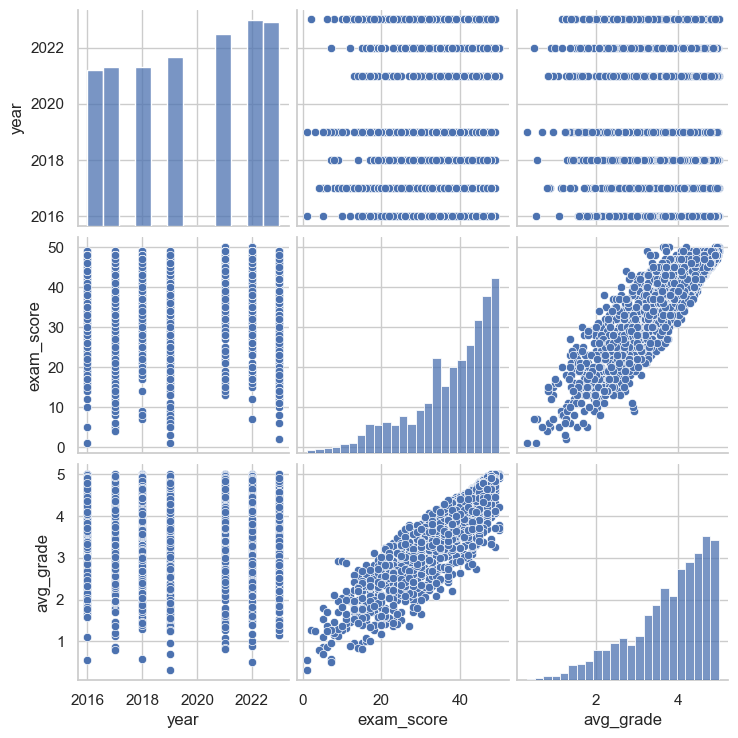

In [68]:
# Detailed distributions by variable
df.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.show()

# Pairwise distributions 
sns.pairplot(df)
plt.show()

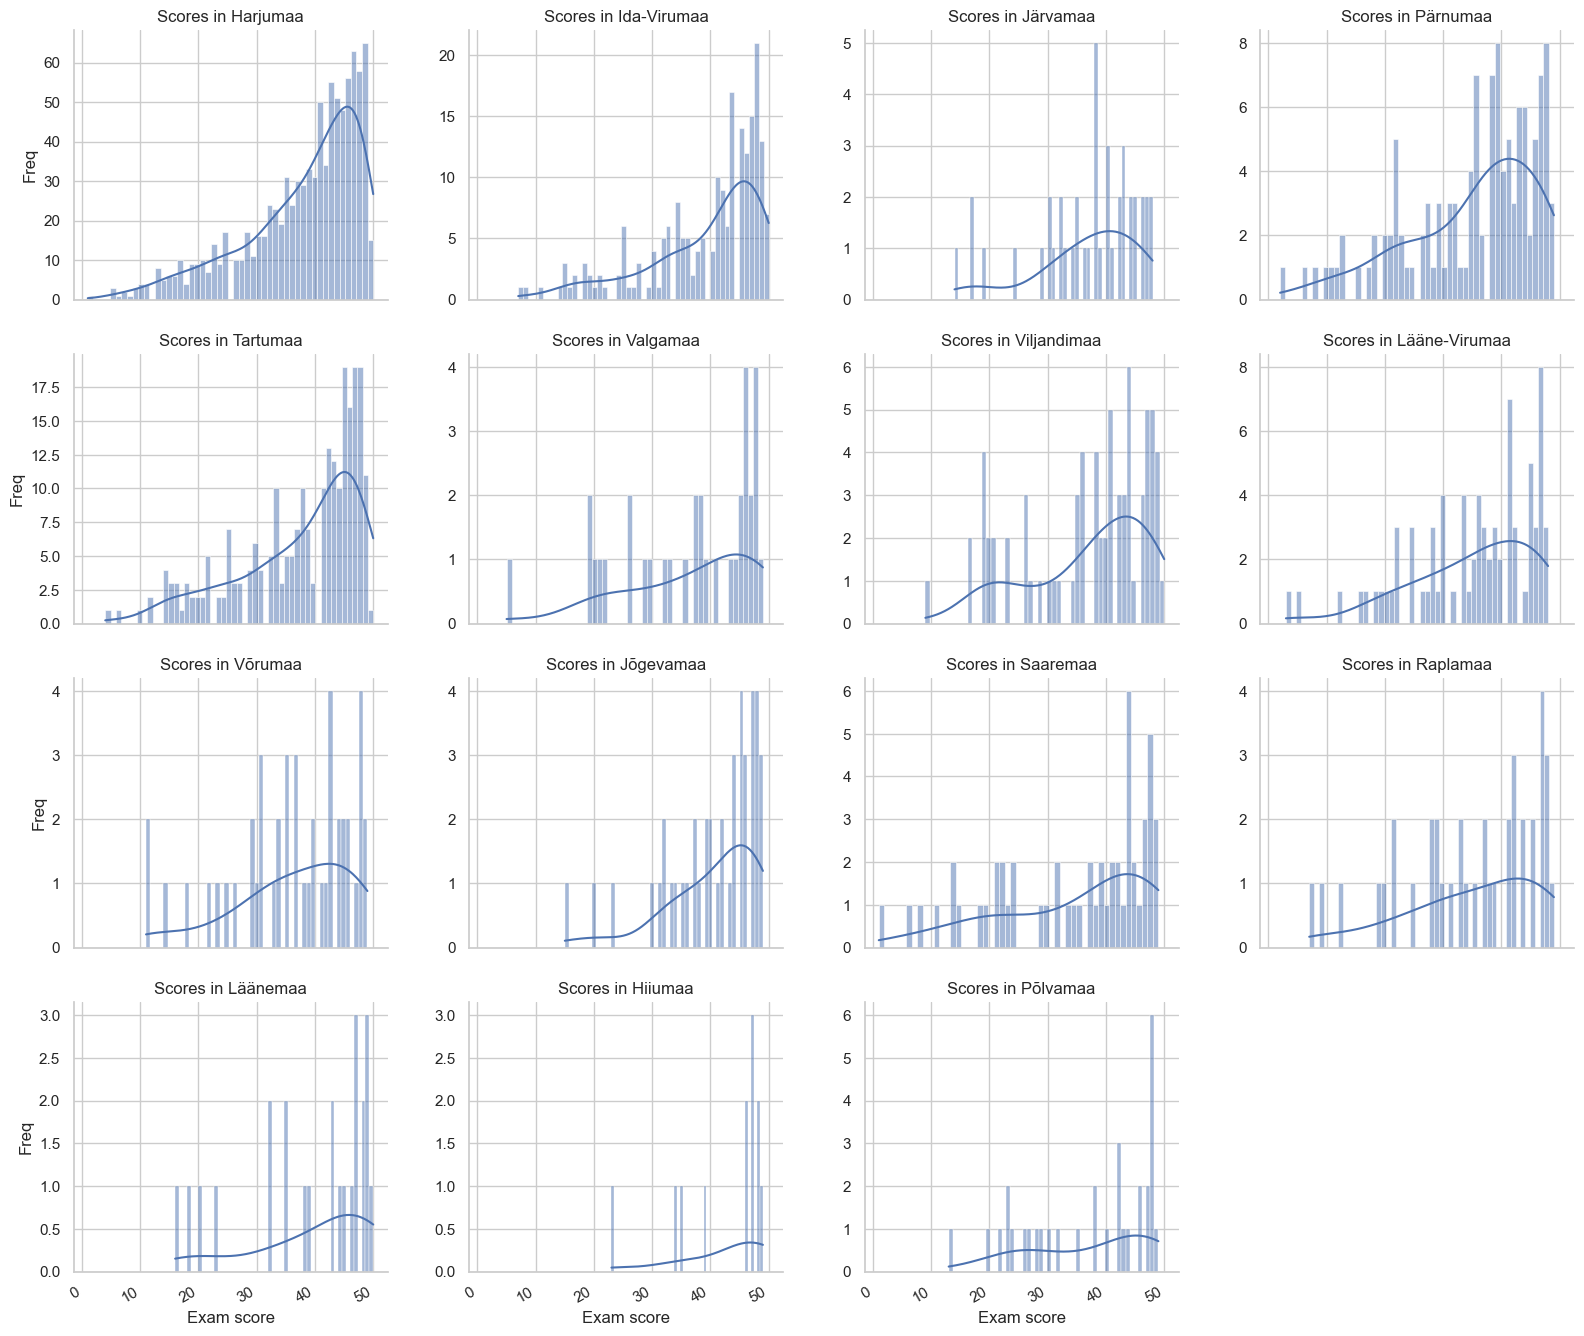

In [70]:
sns.set_theme(style='whitegrid')
g = sns.FacetGrid(df, col='county', col_wrap=4, sharey=False, height=4)
g.map_dataframe(sns.histplot, x='exam_score', bins=51, kde=True)
g.set_axis_labels("Exam score", "Freq")
g.set_titles("Scores in {col_name}")
g.fig.autofmt_xdate()
plt.show()

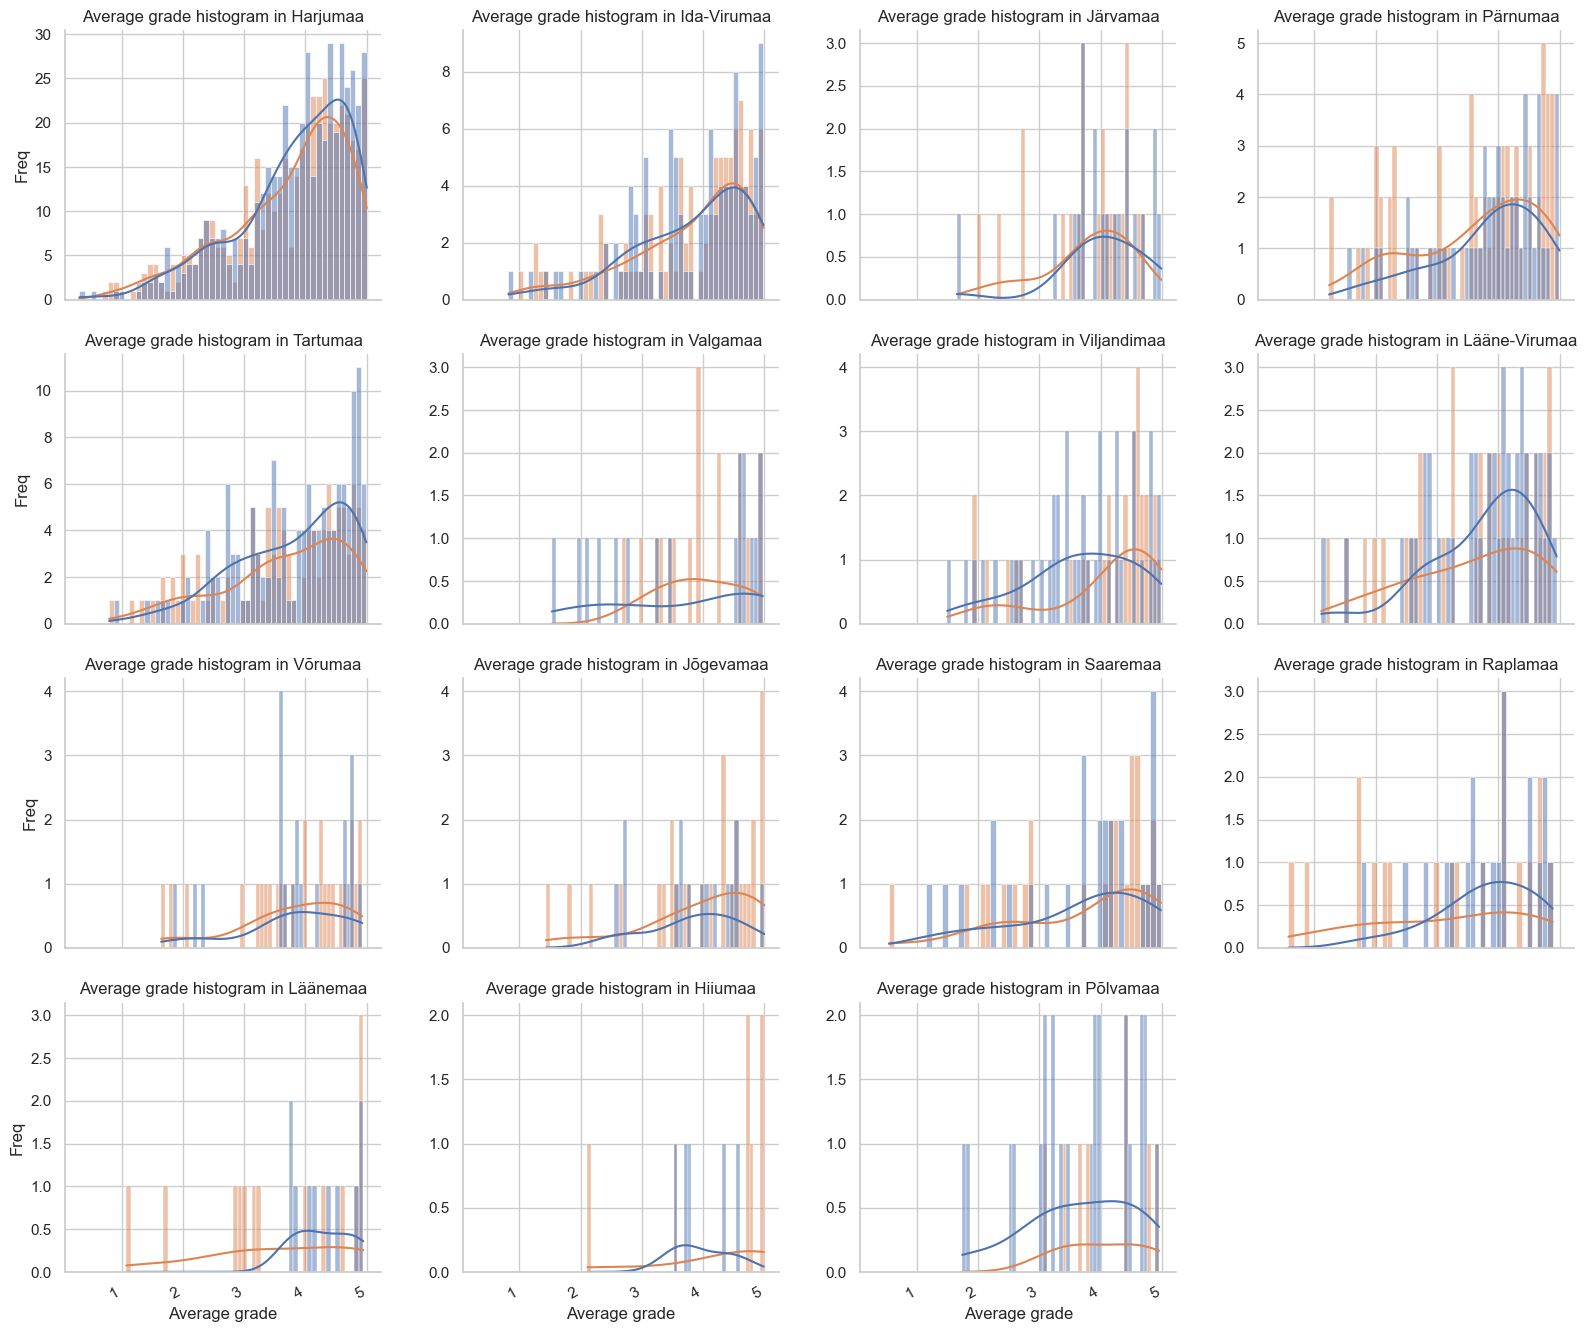

In [110]:
sns.set_theme(style='whitegrid')
g = sns.FacetGrid(df, col='county', col_wrap=4, sharey=False, height=4)
g.map_dataframe(sns.histplot, x='avg_grade', hue='gender', bins=51, kde=True)
g.set_axis_labels("Average grade", "Freq")
g.set_titles("Average grade histogram in {col_name}")
g.fig.autofmt_xdate()
plt.show()

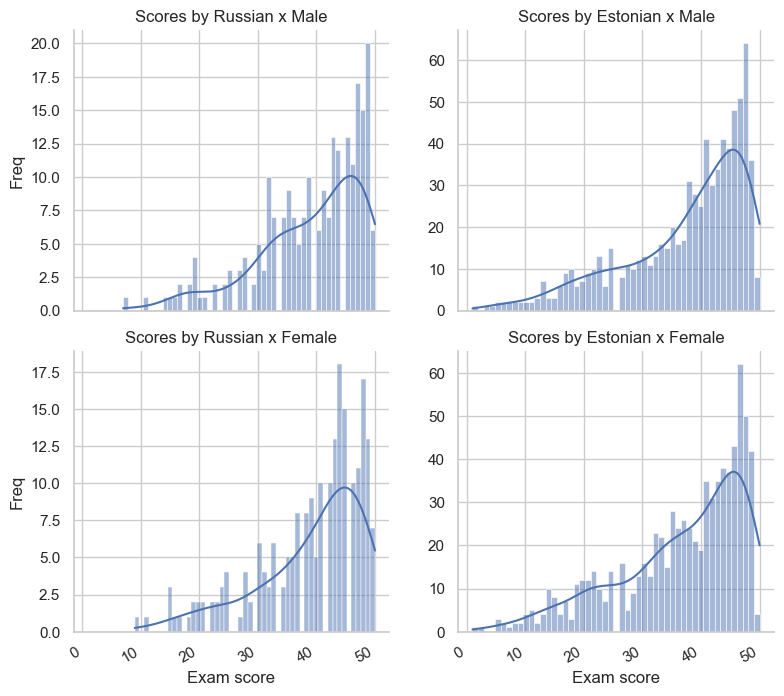

In [72]:
g = sns.FacetGrid(df, col='domestic_background', row='gender', sharey=False, height=4)
g.map_dataframe(sns.histplot, x='exam_score', bins=51, kde=True)
g.set_axis_labels("Exam score", "Freq")
g.set_titles("Scores by {col_name} x {row_name}")
g.fig.autofmt_xdate()
plt.show()

<Axes: xlabel='year', ylabel='exam_score'>

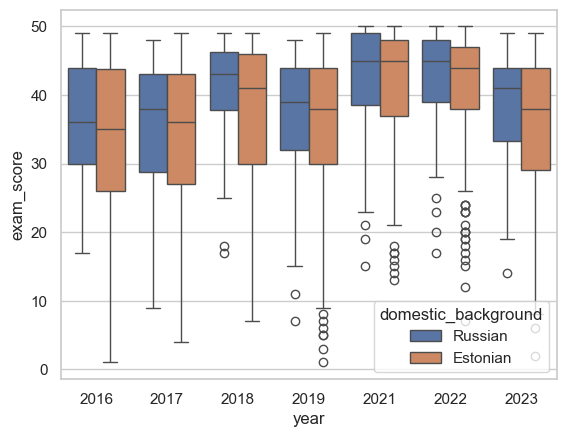

In [108]:
group_sizes = df['county'].value_counts().sort_index()  # group counts by country
normalized_widths = group_sizes / group_sizes.max()      # normalize to [0, 1]

sns.boxplot(df, x='year', y='exam_score', hue='domestic_background')

<Axes: xlabel='year', ylabel='avg_grade'>

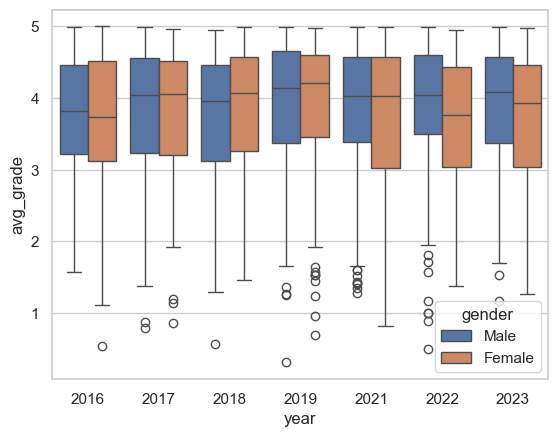

In [80]:
sns.boxplot(df, x='year', y='avg_grade', hue='gender')

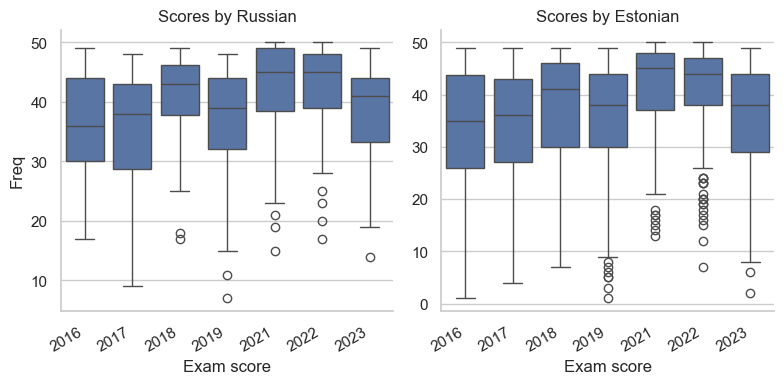

In [106]:
g = sns.FacetGrid(df, col='domestic_background', sharey=False, height=4)
g.map_dataframe(sns.boxplot, x='year', y='exam_score', dodge=False)
g.set_axis_labels("Exam score", "Freq")
g.set_titles("Scores by {col_name}")
g.fig.autofmt_xdate()
plt.show()

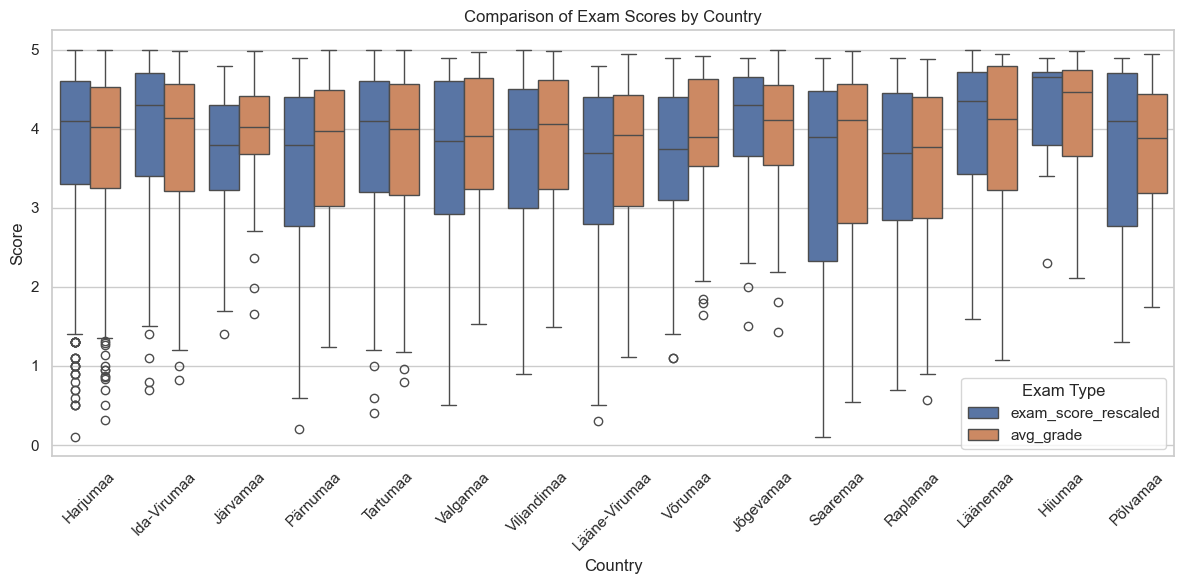

In [100]:
# Melt the data to long format
df['exam_score_rescaled'] = df.exam_score / 10.0
df_long = df.melt(id_vars='county', 
                  value_vars=['exam_score_rescaled', 'avg_grade'],
                  var_name='score_type', 
                  value_name='score')

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_long,
    x='county',
    y='score',
    hue='score_type'
)

plt.title("Comparison of Exam Scores by Country")
plt.xlabel("Country")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Exam Type")
plt.tight_layout()
plt.show()

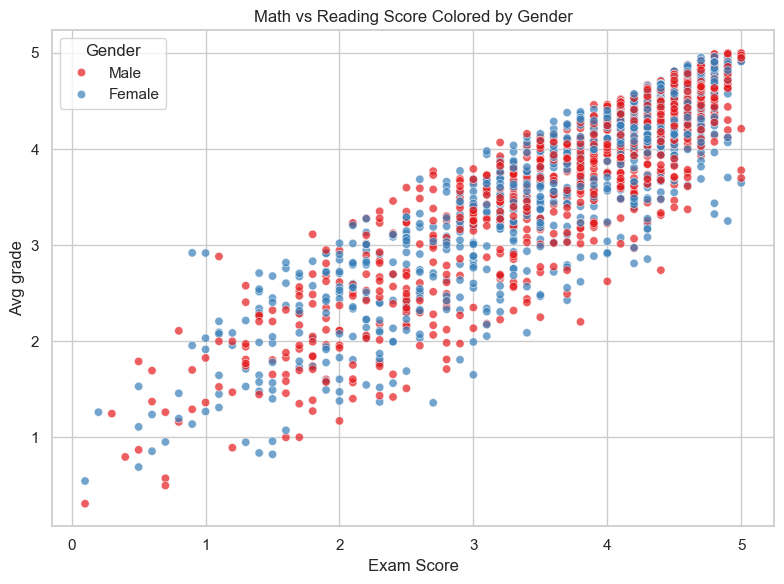

In [104]:
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="exam_score_rescaled",
    y="avg_grade",
    hue="gender",          # color by gender
    palette="Set1",        # optional: change color palette
    alpha=0.7              # optional: transparency for overlapping points
)

plt.title("Math vs Reading Score Colored by Gender")
plt.xlabel("Exam Score")
plt.ylabel("Avg grade")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

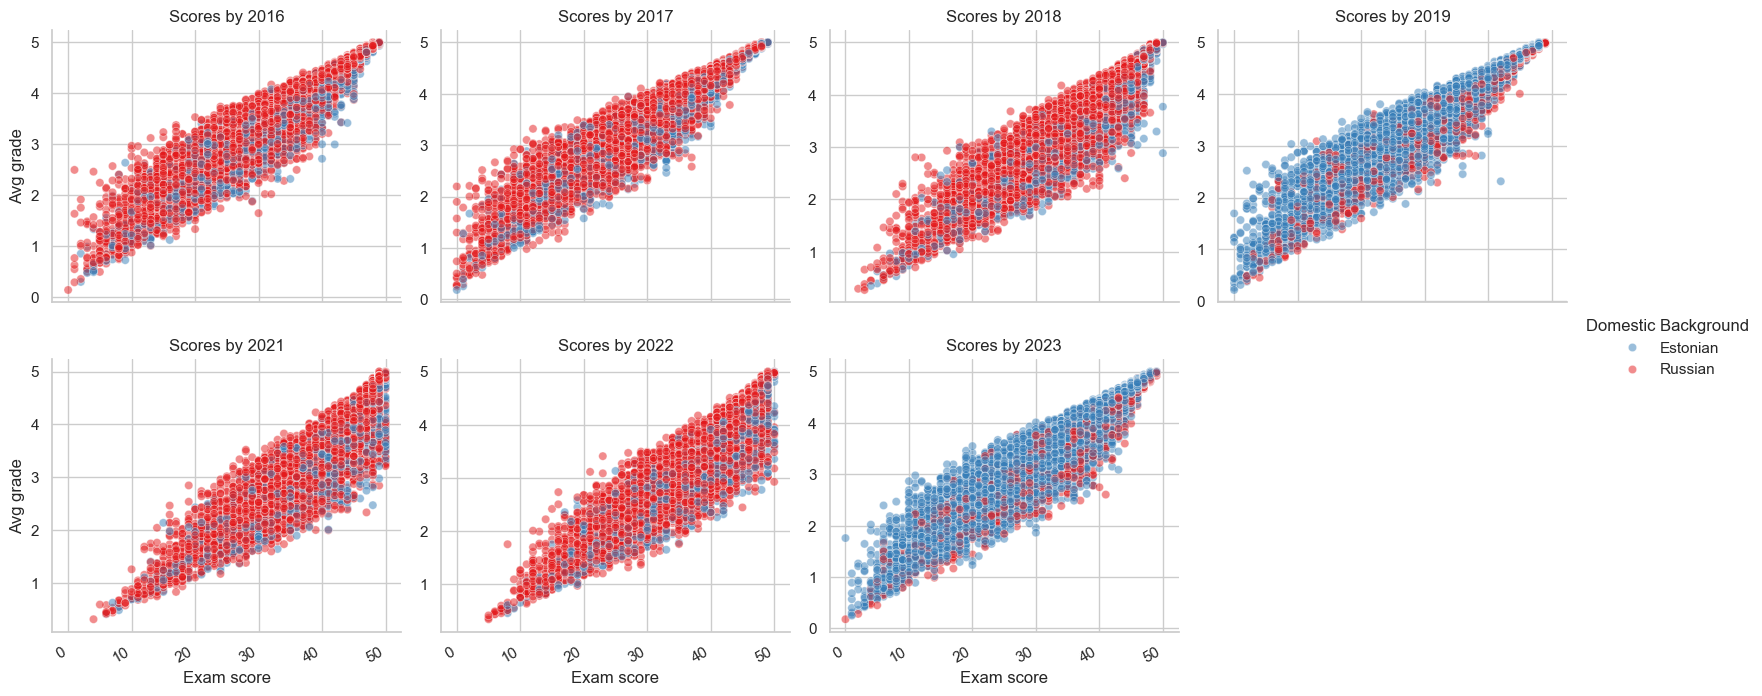

In [192]:
g = sns.FacetGrid(df, col='year', sharey=False, height=4, col_wrap=4)
g.map_dataframe(sns.scatterplot, x="exam_score", y="avg_grade", hue="domestic_background", palette="Set1", alpha=0.5)
g.set_axis_labels("Exam score", "Avg grade")
g.set_titles("Scores by {col_name}")
g.fig.autofmt_xdate()
g.add_legend(title="Domestic Background")
plt.show()

   year domestic_background  count  proportion
0  2016            Estonian    178    0.709163
1  2016             Russian     73    0.290837
2  2017            Estonian    204    0.796875
3  2017             Russian     52    0.203125
4  2018            Estonian    191    0.749020


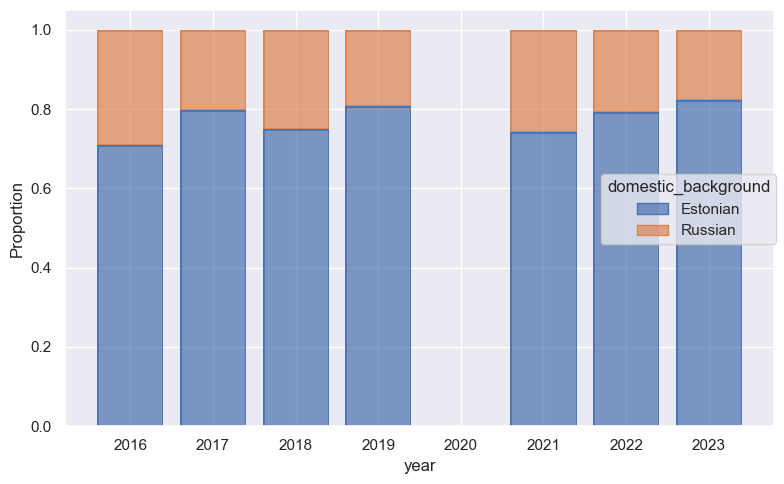

In [146]:
# Make sure you're using seaborn >= 0.12
# Normalize counts to proportions within each year
df_counts = (
    df
    .groupby(['year', 'domestic_background'])
    .size()
    .reset_index(name='count')
)

# Normalize to 100%
df_counts['proportion'] = (
    df_counts
    .groupby('year')['count']
    .transform(lambda x: x / x.sum())
)

print(df_counts.head())

# Plot using the new seaborn.objects interface
from seaborn.objects import Plot, Bar, Stack

# Step 2: Plot using seaborn.objects
p = (
    Plot(df_counts, x="year", y="proportion", color="domestic_background").add(Bar(), Stack())  # ← this stacks the bars
)

# Step 3: Format and show
p.label(y="Proportion") \
 .theme({"axes.grid": True}) \
 .layout(size=(8, 5)) \
 .show()

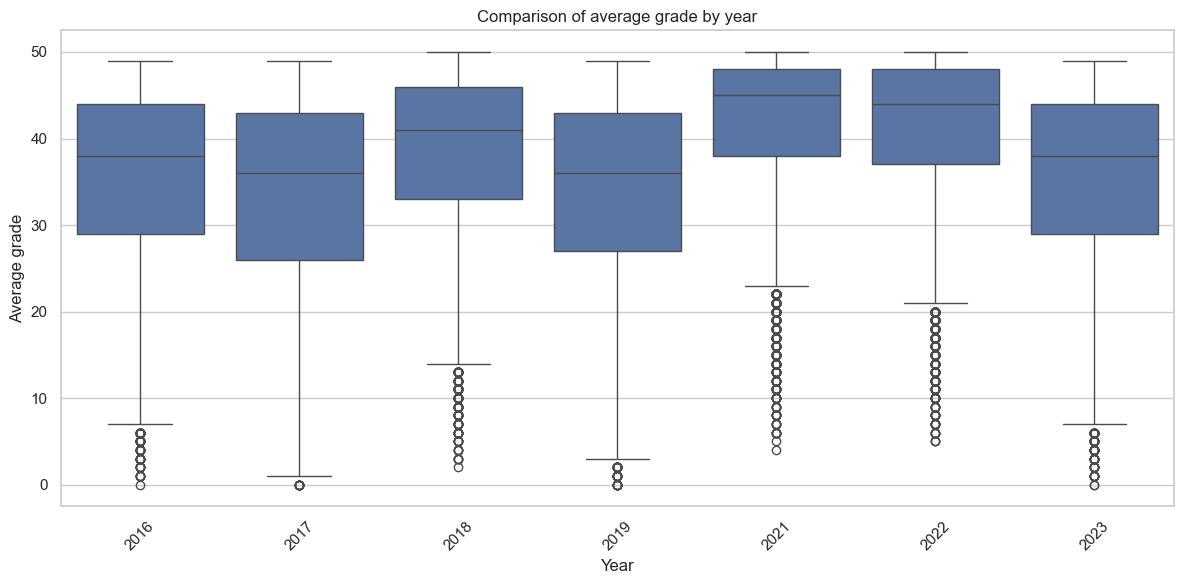

In [194]:
# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df,
    x='year',
    y='exam_score'
)

plt.title("Comparison of average grade by year")
plt.xlabel("Year")
plt.ylabel("Average grade")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

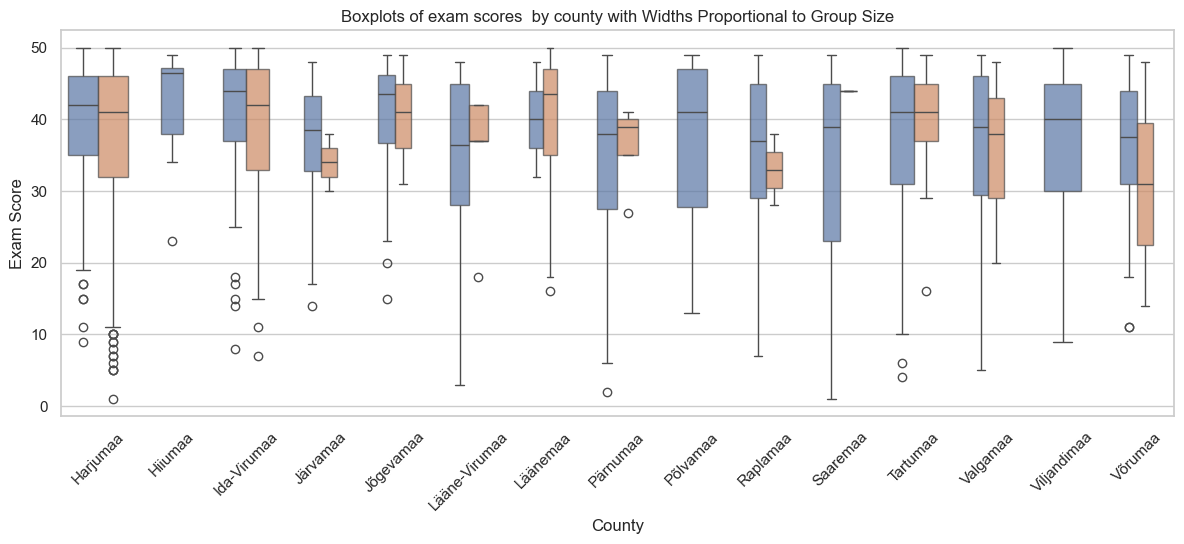

In [186]:
# Example DataFrame: df with columns 'country', 'exam_score'
group_sizes = df['county'].value_counts().sort_index()  # group counts by country
group_sizes = np.log10(group_sizes)
normalized_widths = group_sizes / group_sizes.max()      # normalize to [0, 1]

# Set up figure
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Store unique countries for consistent order
counties = sorted(df['county'].unique())

# Plot each boxplot individually with different width
for i, county in enumerate(counties):
    subset = df[df['county'] == county]
    sns.boxplot(
        x=[i]*len(subset),         # x-axis index
        y=subset['exam_score'],
        hue=subset['domestic_background'],
        width=normalized_widths[county]*0.8,  # scale width
        boxprops=dict(alpha=0.7),
    )

# Fix x-axis labels
plt.xticks(range(len(counties)), counties, rotation=45)
plt.xlabel("County")
plt.ylabel("Exam Score")
plt.title("Boxplots of exam scores  by county with Widths Proportional to Group Size")
plt.tight_layout()
plt.legend([],[], frameon=False)
plt.show()